# One dimensional implementations different packages

Import general packages

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Establish benchmark one-dimensional dataset

In [83]:
# Define parameters for the 2D Gaussian distributions
a = np.linspace(-5, 5, 100)  # X-axis
b = np.linspace(-5, 5, 100)  # Y-axis
t = np.linspace(-5, 5, 100) 
A, B = np.meshgrid(a, b)

# Create a function to generate a 2D Gaussian distribution
def gaussian_2d(a, b, a0, b0, sigma_a, sigma_b, t_i):
    return np.exp(-((a - a0) ** 2 / (2 * sigma_a ** 2) + (b - b0) ** 2 / (2 * sigma_b ** 2))) * np.exp(-(t_i ** 2) / 2)

np.random.seed(42)
t_sample = np.random.choice(t, 10, replace=False)  # Randomly sample 10 values from t
y_all = []
y_sample = []

for t_i in t:
    gaus = gaussian_2d(A, B, 0, 0, 1, 1, t_i)
    y_all.append(np.mean(gaus))  # Taking mean value for each z, but you can adjust this

for t_i in t_sample:
    gaus = gaussian_2d(A, B, 0, 0, 1, 1, t_i)
    y_sample.append(np.mean(gaus))  # Taking mean value for each z, but you can adjust this

X_all = np.array(t.reshape(-1,1))
y_all = np.array(y_all).reshape(-1,1)

X = np.array(t_sample.reshape(-1,1))
y = np.array(y_sample)

y_mean = np.mean(y)
y_norm = (y - y_mean)/np.std(y)

Define colors for plotting

In [84]:
colors = ['firebrick', 'darkslategray', 'forestgreen']

## Compare different packages

Define parameters

In [85]:
# Linear model parameters for kriging, scikit-learn
linear_model_parameters = {'slope': 1, 'nugget': 0}

In [86]:
# Gaussian, exponential model parameters for kriging 
kriging_variogram_parameters = {'sill': 0.0006, 'range': 2.3, 'nugget': 0}

In [87]:
# Gaussian, exponential model parameters for gpytorch - from Romain
def convert_kernel_pykrige_to_gp(model_name, range_val, sill) -> tuple[str, float, float]:
    """

    :param model_name: Name of model in PyKrige.
    :param range_val: Range of model.
    :param sill: Sill of model.

    :return: Name of model in GPs, Lenghtscale, Outputscale
    """

    if model_name == "gaussian":
        # Lengthscale for gaussian in PyKrige: EXP(D**2 / A**2) with A = 4/7*R
        # https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/variogram_models.html#variogram-models

        # Lengthscale for RBF in GPs: EXP(-1/2 * D**2 / A**2)  (notice the 1/2 added at start of the EXP)
        # https://docs.gpytorch.ai/en/stable/kernels.html#rbfkernel

        # So 2A**2 = (4/7R)**2

        gp_model_name = "RBF"
        gp_lengthscale = range_val * (4/7) / np.sqrt(2)
        gp_outputscale = sill

    elif model_name == "exponential":
        # Lengthscale for exponential in PyKrige: EXP(D / A) with A = R/3
        # https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/variogram_models.html#variogram-models

        # Lengthscale for Matern with 1/2 smoothness in GPs (equivalent to exponential, see for instance https://scikit-gstat.readthedocs.io/en/latest/reference/models.html#matern-model):
        # EXP(-1/2 * D / A)  (notice the 1/2 added at start of the EXP)
        # https://docs.gpytorch.ai/en/stable/kernels.html#rbfkernel

        gp_model_name = "Matern"
        # Unsure about this one, but it looks like in SciKit-GStat the matern with scale 1/2 equals the exponential at same range,
        # and the exponential has R/3 and Matern R/2, so should be 2/3...
        gp_lengthscale = range_val * 2 / 3
        gp_outputscale = sill

    else:
        raise ValueError("model_name should be one of {}".format(["gaussian", "exponential"]))

    return gp_model_name, gp_lengthscale, gp_outputscale

### 1 - pykrige

In [88]:
# %pip install pykrige

In [89]:
from pykrige.ok import OrdinaryKriging

Linear
RMSE: 0.0029

Gaussian
RMSE: 0.0023

Exponential
RMSE: 0.0057



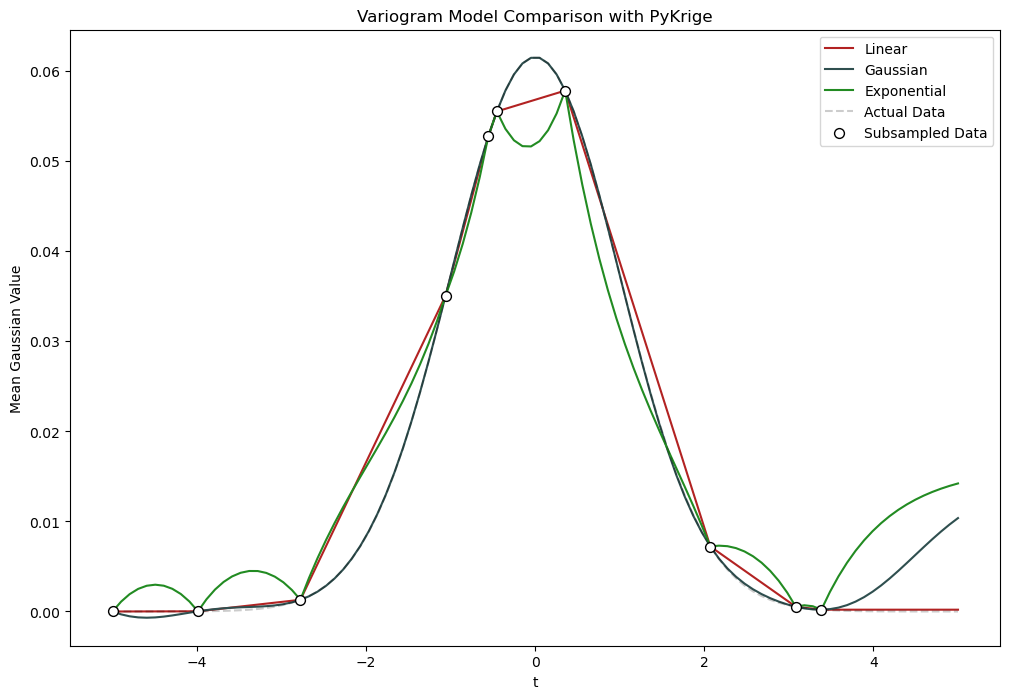

In [90]:
# Define the variogram models to test
variogram_model_dict = {'Linear':'linear', 
                        'Gaussian': 'gaussian',
                        'Exponential': 'exponential'}

# Plotting results for each variogram model
plt.figure(figsize=(12, 8))
rmse_1 = []

for model_name, model in variogram_model_dict.items():

    # Print parameters
    print(model_name)
    
    if model == 'linear':
        uk = OrdinaryKriging(X.ravel(), np.zeros(X.shape[0]), y_norm, variogram_model=model, variogram_parameters=linear_model_parameters)
        # print(uk.variogram_model_parameters)
    elif model in ['power','spherical','hole-effect']:
        raise NotImplementedError("Power, spherical, and hole-effect variogram models not implemented in this comparison.")

    elif model in ['exponential', 'gaussian']:
        uk = OrdinaryKriging(X.ravel(), np.zeros(X.shape[0]), y_norm, variogram_model=model, variogram_parameters=kriging_variogram_parameters)
        # print(uk.variogram_model_parameters)

    # Perform kriging
    y_pred, y_std = uk.execute("grid", X_all.ravel(), np.array([0.0]))
    y_pred = np.squeeze(y_pred)
    y_pred = y_pred * np.std(y) + np.mean(y)
    
    if model == 'gaussian':
        gaussian_1 = y_pred

    # Compute the rmse of this model compared to the actual data
    rmse = np.sqrt(np.mean((y_pred - y_all.ravel()) ** 2))
    print("RMSE: {:.4f}".format(rmse)) 
    rmse_1.append(rmse)   
    print("")

    # Ploting
    plt.plot(X_all, y_pred, color = colors[list(variogram_model_dict.keys()).index(model_name)], label=model_name)

plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.xlabel("t")
plt.ylabel("Mean Gaussian Value")
plt.title("Variogram Model Comparison with PyKrige")
plt.show()

### 2 - scikit-learn

In [91]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel, Matern

Linear ("linear")
RMSE: 0.021734
RBF ("gaussian")
RMSE: 0.003326
Matern ("exponential")
RMSE: 0.004867


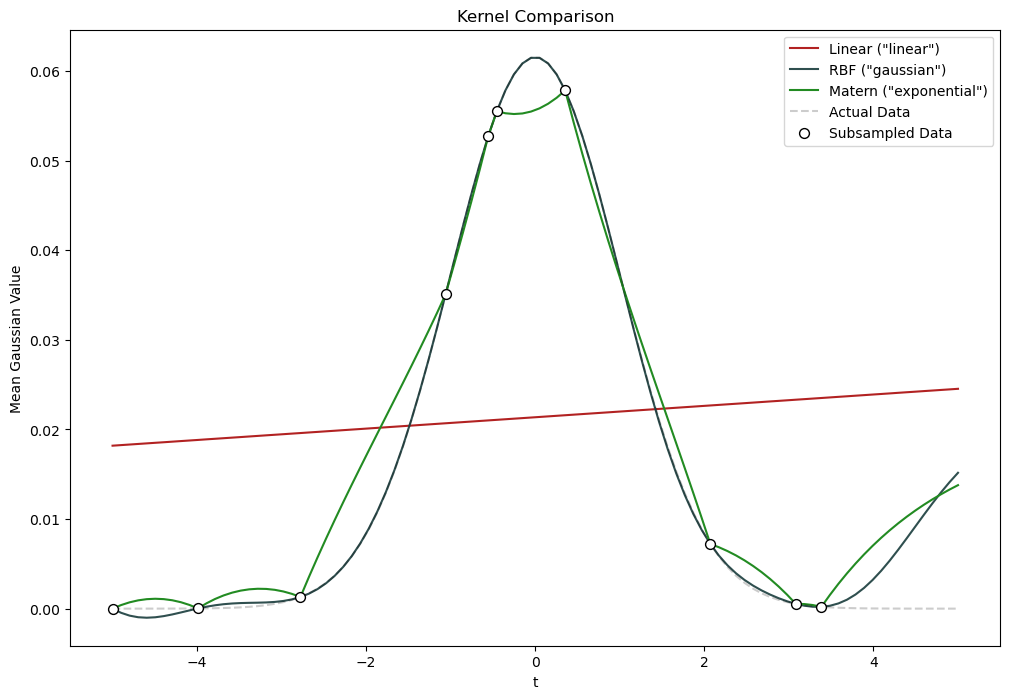

In [92]:
# List of kernels to test, matching those of pykrige, as a dictionary
kernels = ['Linear ("linear")', 'RBF ("gaussian")', 'Matern ("exponential")']

plt.figure(figsize=(12, 8))
rmse_2 = []

for kernel_name in kernels:

    if kernel_name == 'Linear ("linear")':
        kernel = ConstantKernel() + DotProduct()

    elif kernel_name == 'RBF ("gaussian")':
        # set parameters
        sill = kriging_variogram_parameters["sill"]
        range_val = kriging_variogram_parameters["range"]
        gp_model_name, gp_lengthscale, gp_outputscale = convert_kernel_pykrige_to_gp("gaussian", range_val=range_val, sill=sill)

        kernel = ConstantKernel() * RBF(length_scale=gp_lengthscale)

    elif kernel_name == 'Matern ("exponential")':
        # set parameters
        sill = kriging_variogram_parameters["sill"]
        range_val = kriging_variogram_parameters["range"]
        gp_model_name, gp_lengthscale, gp_outputscale = convert_kernel_pykrige_to_gp("exponential", range_val=range_val, sill=sill)
        
        kernel = ConstantKernel() * Matern(length_scale=gp_lengthscale, nu=0.5)
        
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    gpr.fit(X, y_norm)
    
    y_pred, sigma = gpr.predict(X_all, return_std=True)
    y_pred = np.squeeze(y_pred)
    y_pred = y_pred * np.std(y) + np.mean(y)

    if kernel_name == 'RBF ("gaussian")':
        gaussian_2 = y_pred

    print(kernel_name)

    # Compute RMSE
    rmse = np.sqrt(np.mean((y_pred - y_all.ravel()) ** 2))
    print(f"RMSE: {rmse:4f}")
    rmse_2.append(rmse)
    
    # Plotting
    plt.plot(X_all, y_pred, color = colors[kernels.index(kernel_name)], label=kernel_name)

plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.xlabel("t")
plt.ylabel("Mean Gaussian Value")
plt.title("Kernel Comparison")
plt.show()

### 3 - gpytorch

In [93]:
# %pip install torch

In [94]:
# %pip install gpytorch

In [95]:
import torch
import gpytorch

RMSE: 0.021641
RMSE: 0.007883
RMSE: 0.009506


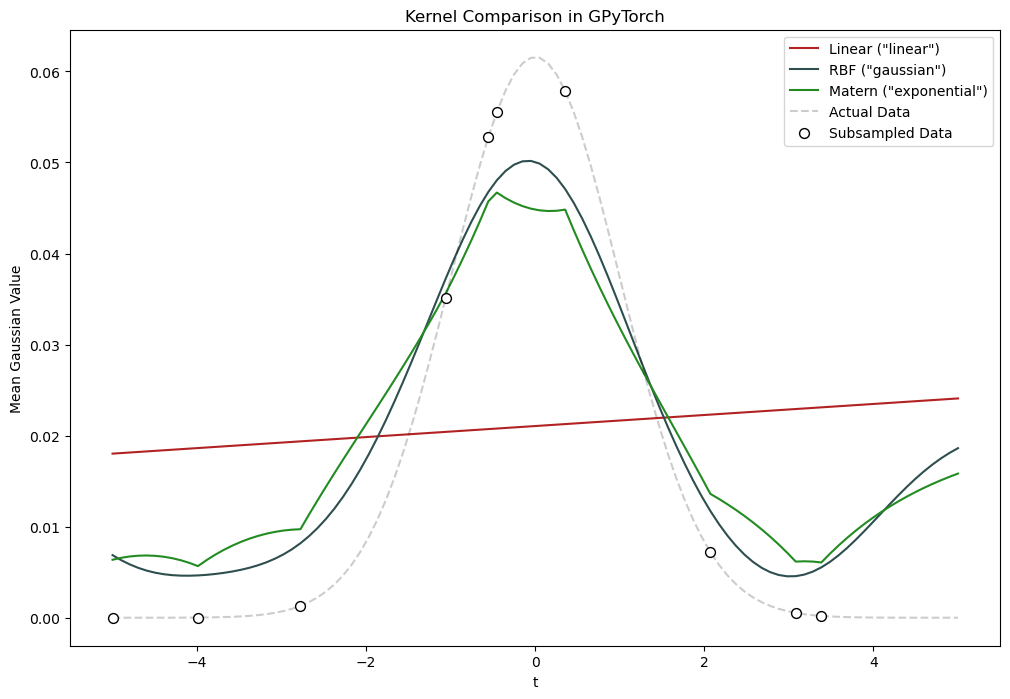

In [113]:
# Convert data to PyTorch tensors
train_x = torch.Tensor(X)
train_y = torch.Tensor(y_norm)
test_x = torch.Tensor(X_all)

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the likelihood and set noise to nugget
nuggget = kriging_variogram_parameters["nugget"]
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(nuggget))

kernels = ['Linear ("linear")', 'RBF ("gaussian")', 'Matern ("exponential")']

plt.figure(figsize=(12, 8))
rmse_3 = []

# Training and predicting for each kernel
for kernel_name in kernels:
    if kernel_name == 'Linear ("linear")':
        kernel = gpytorch.kernels.LinearKernel()

    elif kernel_name == 'RBF ("gaussian")':
        # set parameters
        sill = kriging_variogram_parameters["sill"]
        range_val = kriging_variogram_parameters["range"]
        gp_model_name, gp_lengthscale, gp_outputscale = convert_kernel_pykrige_to_gp("gaussian", range_val=range_val, sill=sill)
        kernel = gpytorch.kernels.RBFKernel()
        kernel.lengthscale = gp_lengthscale
        kernel.outputscale = gp_outputscale

    elif kernel_name == 'Matern ("exponential")':
        # set parameters
        sill = kriging_variogram_parameters["sill"]
        range_val = kriging_variogram_parameters["range"]
        gp_model_name, gp_lengthscale, gp_outputscale = convert_kernel_pykrige_to_gp("exponential", range_val=range_val, sill=sill)
        
        kernel = gpytorch.kernels.MaternKernel(nu=0.5)
        kernel.lengthscale = gp_lengthscale
        kernel.outputscale = gp_outputscale
        
    model = ExactGPModel(train_x, train_y, likelihood, kernel)

    # print(model)
    model.eval()
    likelihood.eval()
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        mean = observed_pred.mean.numpy()
    mean = mean * np.std(y) + np.mean(y)
    
    if kernel_name == 'RBF ("gaussian")':
        gaussian_3 = mean

    # Compute RMSE
    rmse = np.sqrt(np.mean((mean - y_all.ravel()) ** 2))
    print(f"RMSE: {rmse:4f}")
    rmse_3.append(rmse)

    # Plotting
    plt.plot(test_x.numpy(), mean, color = colors[kernels.index(kernel_name)], label=kernel_name)
    
plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.xlabel("t")
plt.ylabel("Mean Gaussian Value")
plt.title("Kernel Comparison in GPyTorch")
plt.show()

### Summary Findings

In [97]:
# Summary rmse table
rmse_1 = np.array(rmse_1)
rmse_2 = np.array(rmse_2)
rmse_3 = np.array(rmse_3)
rmse_table = pd.DataFrame({'PyKrige': rmse_1, 'Scikit-learn': rmse_2, 'GPyTorch': rmse_3}, index=list(variogram_model_dict.keys()))
rmse_table

,PyKrige,Scikit-learn,GPyTorch
Linear,0.002894,0.021734,0.021641
Gaussian,0.002276,0.003326,0.007883
Exponential,0.005703,0.004867,0.009506


Gaussian Comparison

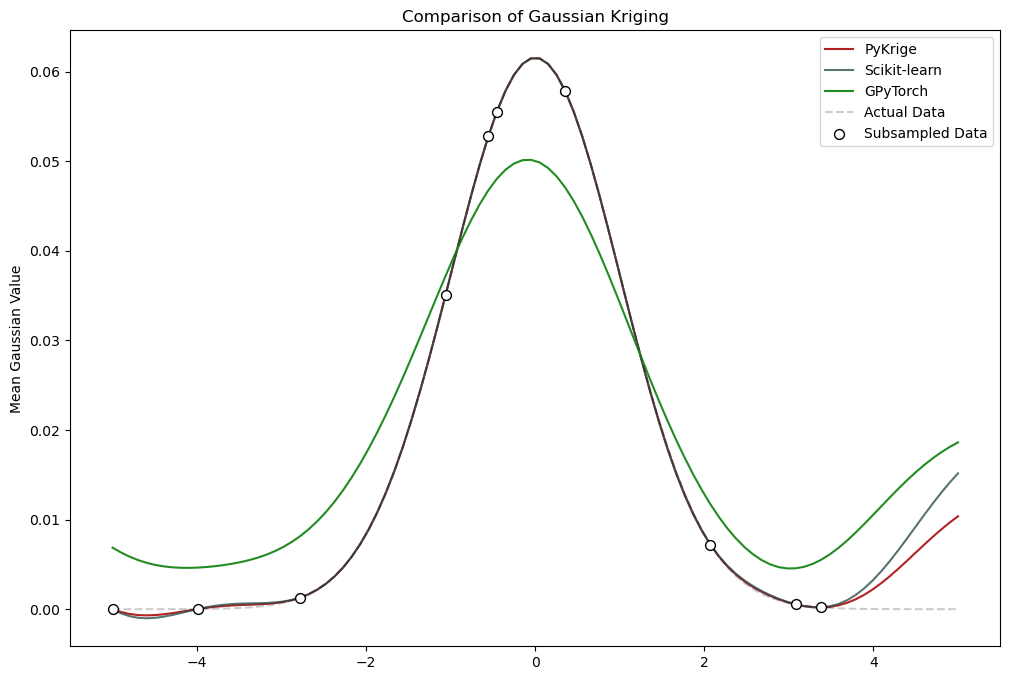

In [98]:
# Show the results for kriging, scikit-learn, and GPyTorch for the Gaussion on the same plot

plt.figure(figsize=(12, 8))
plt.plot(X_all, gaussian_1, color = colors[0], label='PyKrige')
plt.plot(X_all, gaussian_2, color = colors[1], label='Scikit-learn', alpha=0.8)
plt.plot(X_all, gaussian_3, color = colors[2], label='GPyTorch')

plt.plot(X_all, y_all, 'k--', alpha=0.2, label="Actual Data")
plt.scatter(X, y, c='white', s=50, zorder=10, edgecolors=(0, 0, 0), label="Subsampled Data")
plt.legend()
plt.ylabel("Mean Gaussian Value")
plt.title("Comparison of Gaussian Kriging")
plt.show()